# Walmat Sales Data

In [1]:
# Essentials
import pandas as pd
import numpy as np

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns


# Stats Models
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, acf

# Grid Search
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV

# Model Selection

from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Load Dataset

In [3]:
df_stores= pd.read_csv('../../data/stores.csv')
df_features= pd.read_csv('../../data/features.csv')
df_samplesubmission= pd.read_csv('../../data/samplesubmission.csv')
df_test= pd.read_csv('../../data/test.csv')
df_train= pd.read_csv('../../data/train.csv')

### Basic Data Exploration

In [4]:
df_train

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [5]:
df_train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [6]:
df_train.duplicated().sum()

0

In [7]:
df_stores.isnull().sum()

Store    0
Type     0
Size     0
dtype: int64

In [8]:
df_stores.duplicated().sum()

0

In [9]:
df_features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [10]:
df_features.duplicated().sum()

0

In [11]:
df_features[['Store', 'Date', 'CPI', 'Unemployment']]

,Store,Date,CPI,Unemployment
0,1,2010-02-05,211.096358,8.106
1,1,2010-02-12,211.242170,8.106
2,1,2010-02-19,211.289143,8.106
3,1,2010-02-26,211.319643,8.106
4,1,2010-03-05,211.350143,8.106
...,...,...,...,...
8185,45,2013-06-28,NaN,NaN
8186,45,2013-07-05,NaN,NaN
8187,45,2013-07-12,NaN,NaN
8188,45,2013-07-19,NaN,NaN


In [12]:
# Filter the rows where CPI or Unemployment are null
null_cpi_unemployment = df_features[df_features['CPI'].isnull() | df_features['Unemployment'].isnull()]

# Display the rows with missing values in CPI or Unemployment
print(null_cpi_unemployment[['Date', 'CPI', 'Unemployment']].sort_values('Date'))

            Date  CPI  Unemployment
169   2013-05-03  NaN           NaN
715   2013-05-03  NaN           NaN
5083  2013-05-03  NaN           NaN
3263  2013-05-03  NaN           NaN
5265  2013-05-03  NaN           NaN
...          ...  ...           ...
5095  2013-07-26  NaN           NaN
3093  2013-07-26  NaN           NaN
1273  2013-07-26  NaN           NaN
4913  2013-07-26  NaN           NaN
8189  2013-07-26  NaN           NaN

[585 rows x 3 columns]


**The above null values are in the test data.** 

In [13]:
df_features[['Store', 'Date', 'CPI', 'Unemployment']]

,Store,Date,CPI,Unemployment
0,1,2010-02-05,211.096358,8.106
1,1,2010-02-12,211.242170,8.106
2,1,2010-02-19,211.289143,8.106
3,1,2010-02-26,211.319643,8.106
4,1,2010-03-05,211.350143,8.106
...,...,...,...,...
8185,45,2013-06-28,NaN,NaN
8186,45,2013-07-05,NaN,NaN
8187,45,2013-07-12,NaN,NaN
8188,45,2013-07-19,NaN,NaN


In [14]:
cpi_unemployment = df_features[['Store', 'Date', 'CPI', 'Unemployment']].copy()

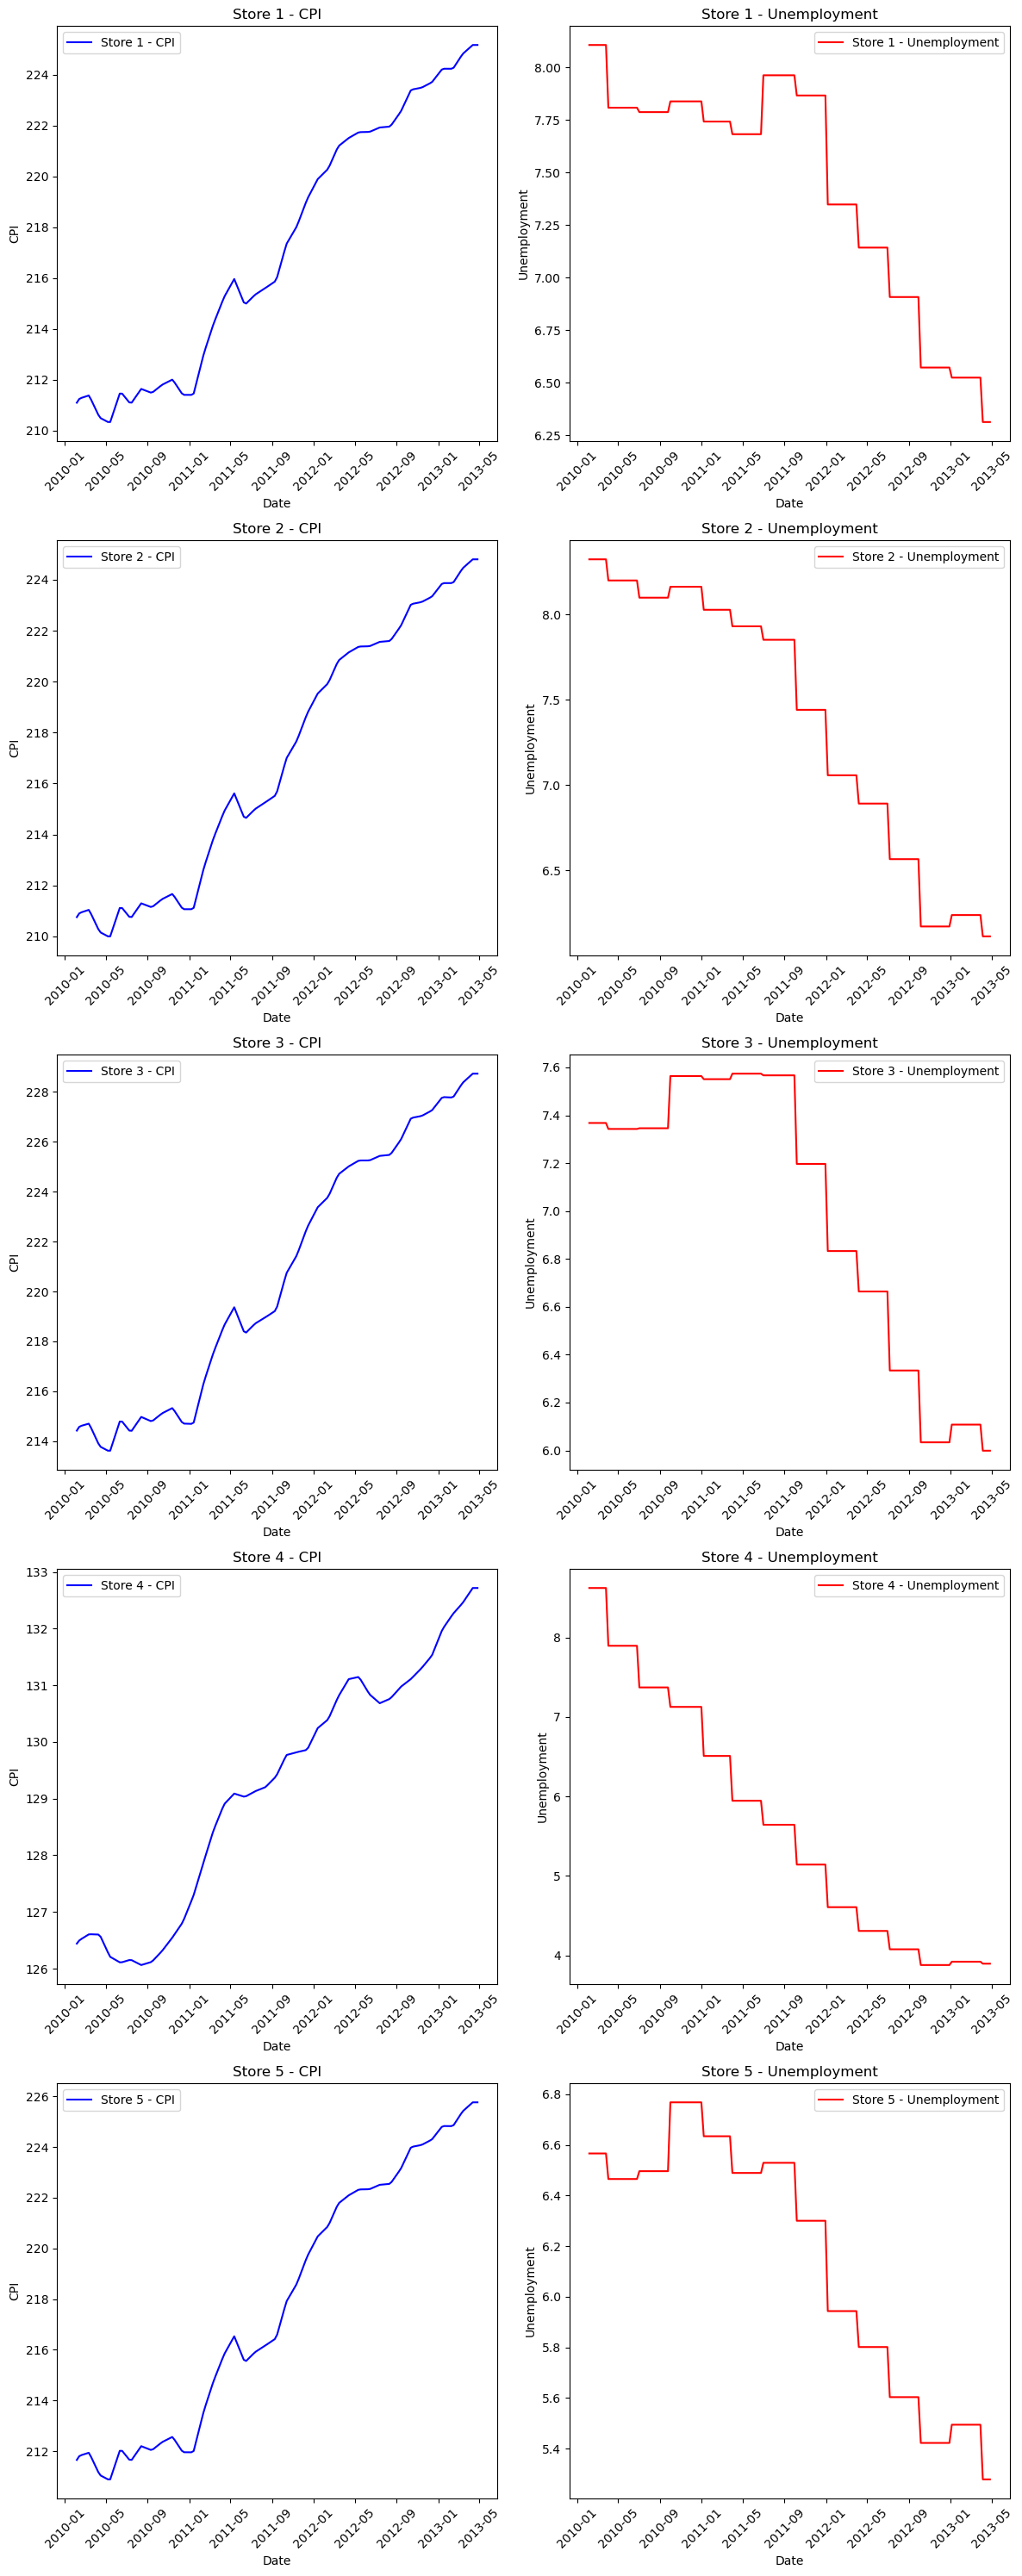

In [15]:
# Ensure the 'Date' column is in datetime format
cpi_unemployment['Date'] = pd.to_datetime(cpi_unemployment['Date'])

# Select the first 5 stores
selected_stores = cpi_unemployment['Store'].unique()[:5]

# Set up the plot for the selected stores
fig, axes = plt.subplots(len(selected_stores), 2, figsize=(12, len(selected_stores) * 6))

for i, store in enumerate(selected_stores):
    store_data = cpi_unemployment[cpi_unemployment['Store'] == store]
    
    # Plot CPI for the current store
    axes[i, 0].plot(store_data['Date'], store_data['CPI'], label=f"Store {store} - CPI", color='blue')
    axes[i, 0].set_title(f"Store {store} - CPI")
    axes[i, 0].set_xlabel('Date')
    axes[i, 0].set_ylabel('CPI')
    axes[i, 0].tick_params(axis='x', labelrotation=45)
    axes[i, 0].legend()
    
    # Plot Unemployment for the current store
    axes[i, 1].plot(store_data['Date'], store_data['Unemployment'], label=f"Store {store} - Unemployment", color='red')
    axes[i, 1].set_title(f"Store {store} - Unemployment")
    axes[i, 1].set_xlabel('Date')
    axes[i, 1].set_ylabel('Unemployment')
    axes[i, 1].tick_params(axis='x', labelrotation=45)
    axes[i, 1].legend()

# Adjust the layout to prevent overlapping labels
plt.tight_layout()
plt.show()

In [16]:
cpi_unemployment.sort_values('Date').head(20)

,Store,Date,CPI,Unemployment
0,1,2010-02-05,211.096358,8.106
2730,16,2010-02-05,189.381697,7.039
5460,31,2010-02-05,210.752605,8.324
3640,21,2010-02-05,210.752605,8.324
4550,26,2010-02-05,131.527903,8.488
7280,41,2010-02-05,189.381697,7.541
2548,15,2010-02-05,131.527903,8.350
5642,32,2010-02-05,189.381697,9.014
910,6,2010-02-05,212.622352,7.259
3458,20,2010-02-05,204.247194,8.187


CPI and Unemployment values are different for each store location.

In [17]:
df_train.sort_values(by=['Store', 'Dept', 'Date'])

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False


In [18]:
df_train['Store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [19]:
df_train['Dept'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
       58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
       91, 92, 93, 94, 95, 96, 97, 98, 99, 39, 50, 43, 65])

In [20]:
df_train.loc[(df_train['Store']==20)]

,Store,Dept,Date,Weekly_Sales,IsHoliday
187335,20,1,2010-02-05,46021.21,False
187336,20,1,2010-02-12,52734.17,True
187337,20,1,2010-02-19,55649.79,False
187338,20,1,2010-02-26,36805.42,False
187339,20,1,2010-03-05,41206.78,False
...,...,...,...,...,...
197544,20,99,2012-09-07,0.67,True
197545,20,99,2012-09-14,0.05,False
197546,20,99,2012-09-21,29.91,False
197547,20,99,2012-10-05,660.00,False


In [21]:
df_train.loc[(df_train['Store']==20) & (df_train['Dept']==2)]

,Store,Dept,Date,Weekly_Sales,IsHoliday
187478,20,2,2010-02-05,85812.69,False
187479,20,2,2010-02-12,67951.33,True
187480,20,2,2010-02-19,78321.16,False
187481,20,2,2010-02-26,72410.12,False
187482,20,2,2010-03-05,81139.43,False
...,...,...,...,...,...
187616,20,2,2012-09-28,73371.54,False
187617,20,2,2012-10-05,82981.54,False
187618,20,2,2012-10-12,75563.24,False
187619,20,2,2012-10-19,72108.34,False


In [22]:
df_train.loc[(df_train['Store']==20) & (df_train['Dept']==1)]

,Store,Dept,Date,Weekly_Sales,IsHoliday
187335,20,1,2010-02-05,46021.21,False
187336,20,1,2010-02-12,52734.17,True
187337,20,1,2010-02-19,55649.79,False
187338,20,1,2010-02-26,36805.42,False
187339,20,1,2010-03-05,41206.78,False
...,...,...,...,...,...
187473,20,1,2012-09-28,32609.37,False
187474,20,1,2012-10-05,40771.47,False
187475,20,1,2012-10-12,41280.48,False
187476,20,1,2012-10-19,40958.43,False


In [23]:
len(df_train.loc[(df_train['Store']==20) & (df_train['Dept']==1)])

143

In [24]:
store_list = df_train['Store'].unique()
len(store_list)

45

In [25]:
dept_list = df_train['Dept'].unique()
len(dept_list)

81

- The training file contains store, department, weekly sales and holiday indicator.
- The test file also contains store, department, weekly sales and holiday indicator but on different date range.
- The store file contains store information such as store type and store size
- The feature files contains additional features including both training and test date range. 
- There are some missing values on the column `MarkDown1`, `MarkDown2`, `MarkDown3`, `MarkDown4`, and `MarkDown5`. We need to set those field without any markdown to 0.
- The other 2 columns containing missing values are `CPI` and `Unemployment`. These data are region specific. Each stores CPI and Unemployment number is different. We will use rolling average of 12 weeks to impute the missing data.
- Time Series is organized by Store and Dept. So we need multi-level-index.

### Action Plan

- This is not for competition used. Therefore, we will ignore test file.
- Denormalize/Merge store file and features files into the training dataset. Set those field without any markdown as 0.
- Convert store type ordinal encoded number.
- Drop duplicated `IsHoliday` column. 

### Denormalize Training Data

In [26]:
df_train_full = df_train.merge(df_stores, on='Store')
df_train_full = df_train_full.merge(df_features, on=['Store', 'Date'])

In [27]:
df_train_full

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,False
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,False
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,False
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,False


In [28]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
 16  IsHoliday_y   421570 non-null  bool   
dtypes: bool(2), float64(10), int64(3), object(2)
mem

In [29]:
df_train_full.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
dtype: int64

In [30]:
df_train_full.duplicated().sum()

0

In [31]:
# Assuming df is your dataset with columns 'Markdown1', 'Markdown2', ..., 'Markdown5'
markdown_columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Set missing values in markdown columns to 0 in the training dataset
df_train_full[markdown_columns] = df_train_full[markdown_columns].fillna(0)

In [32]:
# Create a dictionary to map Store_Type to ordinal values
store_type_map = {'A': 1, 'B': 2, 'C': 3}

# Apply the map function to convert Store_Type to ordinal values
df_train_full['Store_Type_Ordinal'] = df_train_full['Type'].map(store_type_map)

# Drop the original 'Type' column after mapping
df_train_full.drop(columns=['Type'], inplace=True)

In [33]:
df_train_full.isnull().sum()

Store                 0
Dept                  0
Date                  0
Weekly_Sales          0
IsHoliday_x           0
Size                  0
Temperature           0
Fuel_Price            0
MarkDown1             0
MarkDown2             0
MarkDown3             0
MarkDown4             0
MarkDown5             0
CPI                   0
Unemployment          0
IsHoliday_y           0
Store_Type_Ordinal    0
dtype: int64

In [34]:
# Check if the two columns are identical
if df_train_full['IsHoliday_x'].equals(df_train_full['IsHoliday_y']):
    # If the columns are identical, drop one of them
    df_train_full.drop('IsHoliday_y', axis=1, inplace=True)
    print("Columns are identical. 'IsHoliday_y' has been dropped.")
else:
    print("Columns are not identical. No column was dropped.")

Columns are identical. 'IsHoliday_y' has been dropped.


In [35]:
df_train_full.rename(columns={'IsHoliday_x':'IsHoliday' }, inplace=True)

In [36]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Store               421570 non-null  int64  
 1   Dept                421570 non-null  int64  
 2   Date                421570 non-null  object 
 3   Weekly_Sales        421570 non-null  float64
 4   IsHoliday           421570 non-null  bool   
 5   Size                421570 non-null  int64  
 6   Temperature         421570 non-null  float64
 7   Fuel_Price          421570 non-null  float64
 8   MarkDown1           421570 non-null  float64
 9   MarkDown2           421570 non-null  float64
 10  MarkDown3           421570 non-null  float64
 11  MarkDown4           421570 non-null  float64
 12  MarkDown5           421570 non-null  float64
 13  CPI                 421570 non-null  float64
 14  Unemployment        421570 non-null  float64
 15  Store_Type_Ordinal  421570 non-nul

In [37]:
df_train_full['Date'] = pd.to_datetime(df_train_full['Date'])
df_train_full = df_train_full.sort_values(by=["Store", "Dept", "Date"])

## Univariate Analysis

In [38]:
df_ts = df_train_full.set_index('Date')

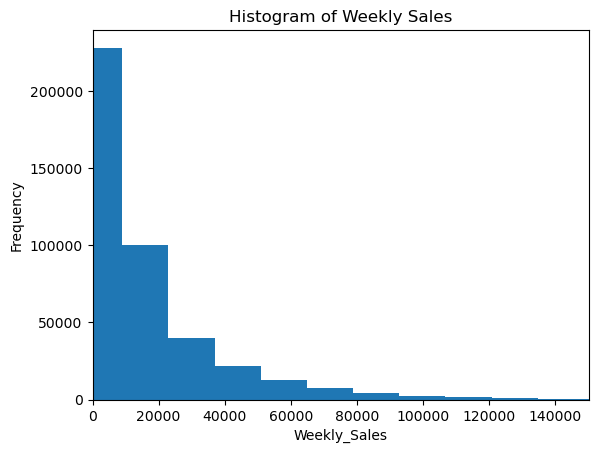

In [39]:
plt.figure()
plt.hist(df_ts["Weekly_Sales"], bins=50)
plt.title("Histogram of Weekly Sales")
plt.xlabel("Weekly_Sales")
plt.ylabel("Frequency")
plt.xlim(0,150000)
plt.show()

Most stores has weekly sales of 10000 and below.

In [40]:
avg_sale_store = df_ts.groupby(by=['Store'])['Weekly_Sales'].mean().sort_values(ascending=False)
avg_sale_store.head(15)

Store
20    29508.301592
4     29161.210415
14    28784.851727
13    27355.136891
2     26898.070031
10    26332.303819
27    24826.984536
6     21913.243624
1     21710.543621
39    21000.763562
19    20362.126734
23    19776.180881
31    19681.907464
11    19276.762751
24    18969.106500
Name: Weekly_Sales, dtype: float64

There are 11 stores that has average weekly sales of more than 20,000 per week.

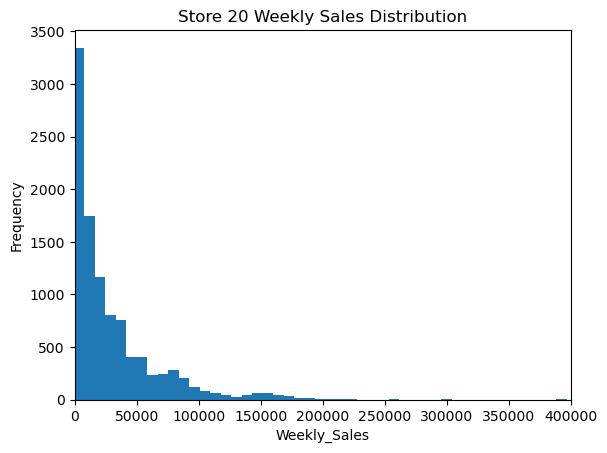

In [41]:
plt.figure()
plt.hist(df_ts.loc[df_ts.Store==20, "Weekly_Sales"], bins=50)
plt.title("Store 20 Weekly Sales Distribution")
plt.xlabel("Weekly_Sales")
plt.ylabel("Frequency")
plt.xlim(0,400000)
plt.show()

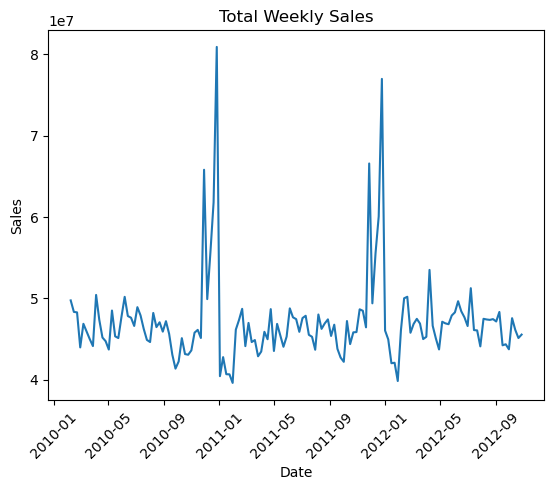

In [42]:
# 3. Now resample on the index
weekly_total = df_ts['Weekly_Sales'].resample('W').sum()

plt.figure()
plt.plot(weekly_total.index, weekly_total.values)
plt.title("Total Weekly Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.show()

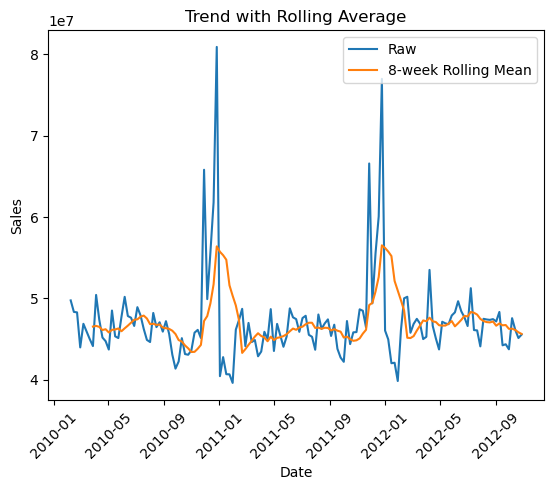

In [43]:
rolling = weekly_total.rolling(window=8).mean()  # 8 weeks
plt.figure()
plt.plot(weekly_total.index, weekly_total.values, label="Raw")
plt.plot(rolling.index,      rolling.values,      label="8-week Rolling Mean")
plt.legend()
plt.title("Trend with Rolling Average")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.show()

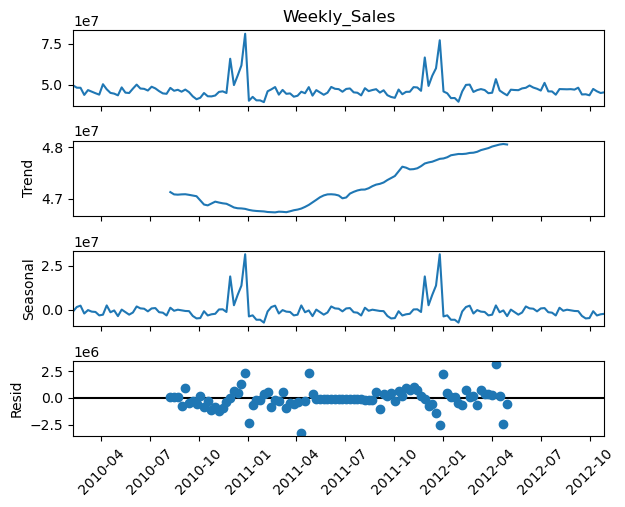

In [44]:
decomp = seasonal_decompose(weekly_total, model="additive", period=52)
decomp.plot()   # gives 4 sub-plots: observed, trend, seasonal, resid
plt.xticks(rotation=45)
plt.show()

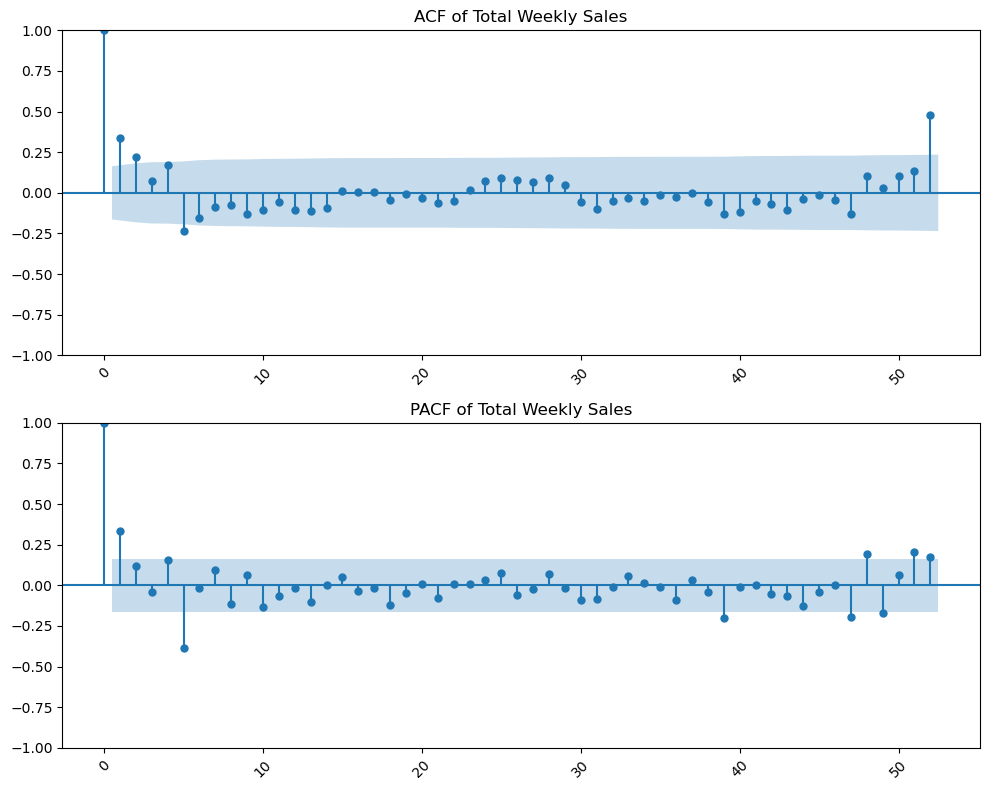

In [45]:
# 1. Plot both in one figure
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# 2. ACF up to 52 lags (one year)
plot_acf(weekly_total, lags=52, ax=axes[0])
axes[0].set_title("ACF of Total Weekly Sales")

# 3. PACF up to 52 lags
plot_pacf(weekly_total, lags=52, ax=axes[1])
axes[1].set_title("PACF of Total Weekly Sales")

# 4. Rotate x-labels for readability
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

In [46]:
acf_values = acf(weekly_total, nlags=52)
acf_values

array([ 1.        ,  0.33740034,  0.22062903,  0.07237072,  0.17385451,
       -0.23191845, -0.15784759, -0.08470098, -0.07518064, -0.12806261,
       -0.10594217, -0.0569027 , -0.10607277, -0.11128366, -0.09176246,
        0.01405238,  0.00254805,  0.00357038, -0.04464742, -0.0071724 ,
       -0.03018732, -0.06308626, -0.05262036,  0.01851845,  0.07355479,
        0.0898217 ,  0.07872612,  0.06787347,  0.08965113,  0.05078368,
       -0.05883777, -0.09798936, -0.04892347, -0.0321189 , -0.05199942,
       -0.01435438, -0.0278777 , -0.00211725, -0.05878667, -0.13084697,
       -0.12009487, -0.04881862, -0.0687944 , -0.10351191, -0.03818367,
       -0.01256552, -0.04220526, -0.12737903,  0.10111208,  0.02770459,
        0.10360507,  0.13673241,  0.47882039])

In [47]:
pacf_values = pacf(weekly_total, nlags=52)
pacf_values

array([ 1.        ,  0.3397764 ,  0.12244675, -0.03948341,  0.16075011,
       -0.3998619 , -0.01882628,  0.10139843, -0.12551005,  0.06950579,
       -0.14895447, -0.07126507, -0.01800783, -0.11996174,  0.00591817,
        0.05934325, -0.03978878, -0.01954788, -0.14425055, -0.05413176,
        0.01532519, -0.10167779,  0.01422124,  0.01089473,  0.03659627,
        0.09999384, -0.07876579, -0.02354271,  0.09296274, -0.02735526,
       -0.11779288, -0.10903293, -0.01903922,  0.08064089,  0.01043005,
       -0.01391232, -0.12249342,  0.04282964, -0.05693797, -0.30328731,
       -0.01246874,  0.00490098, -0.09088446, -0.10498844, -0.22515588,
       -0.07138392, -0.00108962, -0.39504414,  0.3400195 , -0.43499442,
        0.23611926,  0.48138745,  0.11022121])

lags = [1, 2, 3, 6, 52]

rolling means = [4-week, 12-week, 52-week]

### Correlation Analysis

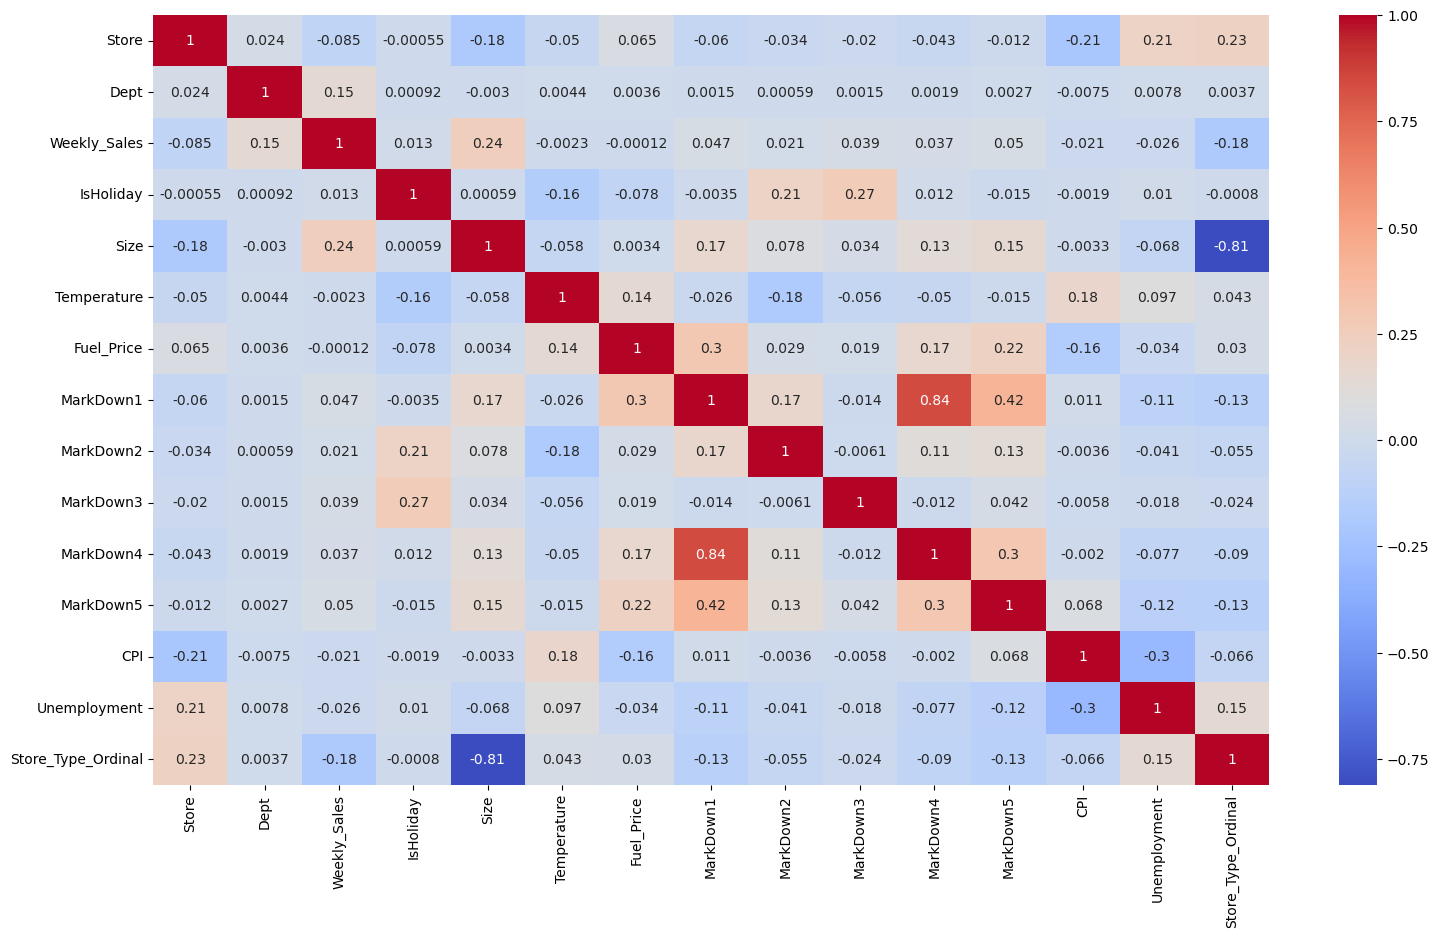

In [48]:
plt.figure(figsize=(18,10))
sns.heatmap(df_ts.corr(), annot=True, cmap='coolwarm')
plt.show()

There seems to have little or no correlation. Between features, there is a relatively high correlation between `MarkDown1` and `MarkDown4`.

### Bi-variate Analysis

Since there is little correlation, the main analysis will be on the lag between features and weekly sales.

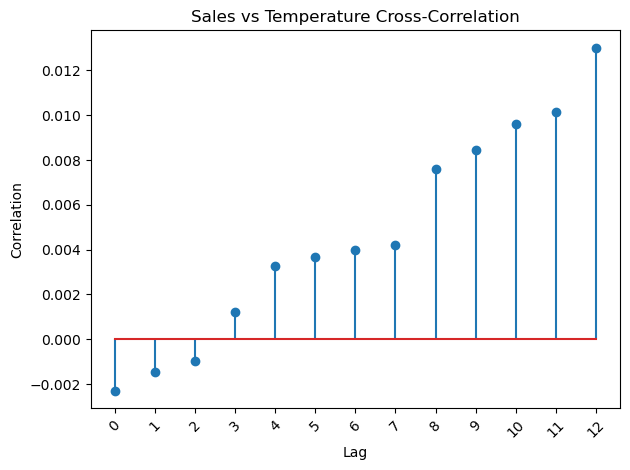

In [49]:
df_ts = df_train_full.set_index('Date').copy()

# assume df_ts is your DataFrame indexed by Date
sales = df_ts['Weekly_Sales']
temp  = df_ts['Temperature']

# compute CCF up to lag 12
max_lag = 12
corrs = [sales.corr(temp.shift(lag)) for lag in range(max_lag+1)]

# compute your cross-correlations into `corrs` as before
lags = list(range(max_lag+1))

plt.figure()
markerline, stemlines, baseline = plt.stem(lags, corrs)   # no use_line_collection
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Sales vs Temperature Cross-Correlation")

# rotate x-ticks if you need
plt.xticks(lags, rotation=45)

plt.tight_layout()
plt.show()

There is little correlation

The following is GPT Analysis of lag analysis with weekly sales and other features.

In [50]:
def covar_lag_corrs(df_ts, covar, max_lag=12):
    """Return list of corr( sales, covar.shift(lag) ) for lag=0..max_lag."""
    sales = df_ts['Weekly_Sales']
    return [
        sales.corr(df_ts[covar].shift(lag))
        for lag in range(max_lag+1)
    ]

covariates = ['Temperature','Fuel_Price','CPI','Unemployment',
              'MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
lag_corrs = {
  cov: covar_lag_corrs(df_ts, cov, max_lag=12)
  for cov in covariates
}

In [51]:
threshold = 2 / np.sqrt(143)
threshold

0.16724840200141816

In [52]:
selected_lags = {}
for cov, corrs in lag_corrs.items():
    sigs = [lag for lag, c in enumerate(corrs) if abs(c) > threshold]
    if sigs:
        selected_lags[cov] = sigs

print("Covariates with significant lags:", selected_lags)

Covariates with significant lags: {}


In [53]:
from scipy.stats import pearsonr
def significant_lags(series_y, series_x, max_lag=12, alpha=0.05):
    sig_lags = []
    for lag in range(1, max_lag+1):
        y = series_y.iloc[lag:]                   # drop first `lag`
        x = series_x.shift(lag).iloc[lag:]        # align
        valid = y.notna() & x.notna()
        if valid.sum() < 10:                      # too few points
            continue
        r, p = pearsonr(y[valid], x[valid])
        if p < alpha:
            sig_lags.append((lag, r, p))
    return sig_lags

# Example on aggregated weekly_total vs aggregated CPI:
sig_cpi = significant_lags(weekly_total, df_ts['CPI'].resample('W').mean())
print("Significant CPI lags:", sig_cpi)

Significant CPI lags: []


### Feature Engineering

- Convert store and dept number to categorical data.
- Add time component: year, month, week of year and day of week.
- Create lags of `[1, 2, 3, 6, 52]` and moving average of `[4-week, 12-week, 52-week]`

In [54]:
df = df_train_full.copy()

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Store               421570 non-null  int64         
 1   Dept                421570 non-null  int64         
 2   Date                421570 non-null  datetime64[ns]
 3   Weekly_Sales        421570 non-null  float64       
 4   IsHoliday           421570 non-null  bool          
 5   Size                421570 non-null  int64         
 6   Temperature         421570 non-null  float64       
 7   Fuel_Price          421570 non-null  float64       
 8   MarkDown1           421570 non-null  float64       
 9   MarkDown2           421570 non-null  float64       
 10  MarkDown3           421570 non-null  float64       
 11  MarkDown4           421570 non-null  float64       
 12  MarkDown5           421570 non-null  float64       
 13  CPI                 421570 no

In [56]:
# ─────────────── 2. Encode & Sort ───────────────
df["Store_cat"] = df["Store"].astype("category").cat.codes
df["Dept_cat"]  = df["Dept"].astype("category").cat.codes
df = df.sort_values(["Store_cat","Dept_cat","Date"]).reset_index(drop=True)

In [57]:
# ─────────────── 3. Date Features ───────────────
df["year"]       = df["Date"].dt.year
df["month"]      = df["Date"].dt.month
df["weekofyear"] = df["Date"].dt.isocalendar().week
df["dayofweek"]  = df["Date"].dt.weekday
df['weekofyear'] = df['weekofyear'].astype(int)

In [58]:
# ─────── 5. Lag & Rolling‐Mean Features (fixed) ───────
LAGS = [1, 2, 3, 6, 52]
ROLL_WINDOWS = [4, 12, 52]

# 5.1 Lags of the target using transform (no reset_index needed)
for lag in LAGS:
    df[f"lag_{lag}"] = df.groupby(["Store_cat","Dept_cat"])["Weekly_Sales"] \
                        .transform(lambda s: s.shift(lag))

# 5.2 Rolling means of the target (excludes current week)
for w in ROLL_WINDOWS:
    df[f"roll_mean_{w}"] = df.groupby(["Store_cat","Dept_cat"])["Weekly_Sales"] \
                             .transform(lambda s: s.shift(1).rolling(window=w).mean())

# 5.3 Drop rows missing any of the new features
new_feats = [f"lag_{l}" for l in LAGS] + [f"roll_mean_{w}" for w in ROLL_WINDOWS]
df = df.dropna(subset=new_feats).reset_index(drop=True)


### Train Test Split

In [59]:
# Number of weeks to hold out
test_weeks = 12
val_weeks  = 12

# Get the sorted list of unique dates
unique_dates = df['Date'].sort_values().unique()

# Determine the cut-off dates
test_start = unique_dates[-test_weeks]
val_start  = unique_dates[-(test_weeks + val_weeks)]

# Split
train_df = df[df['Date'] <  val_start].copy()
val_df   = df[(df['Date'] >= val_start) & (df['Date'] < test_start)].copy()
test_df  = df[df['Date'] >= test_start].copy()

# Quick sanity check
print("Train: ", train_df['Date'].min().date(), "→", train_df['Date'].max().date(),
      f"({len(train_df)} rows)")
print("Valid: ", val_df  ['Date'].min().date(), "→", val_df  ['Date'].max().date(),
      f"({len(val_df  )} rows)")
print("Test : ", test_df ['Date'].min().date(), "→", test_df ['Date'].max().date(),
      f"({len(test_df )} rows)")


Train:  2011-02-04 → 2012-05-11 (191413 rows)
Valid:  2012-05-18 → 2012-08-03 (34703 rows)
Test :  2012-08-10 → 2012-10-26 (34967 rows)


In [60]:
X_train, y_train = train_df.drop(columns=['Weekly_Sales','Date']), train_df['Weekly_Sales']
X_val,   y_val   =   val_df.drop(columns=['Weekly_Sales','Date']),   val_df['Weekly_Sales']
X_test,  y_test  =  test_df.drop(columns=['Weekly_Sales','Date']),  test_df['Weekly_Sales']

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191413 entries, 0 to 261058
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Store               191413 non-null  int64  
 1   Dept                191413 non-null  int64  
 2   IsHoliday           191413 non-null  bool   
 3   Size                191413 non-null  int64  
 4   Temperature         191413 non-null  float64
 5   Fuel_Price          191413 non-null  float64
 6   MarkDown1           191413 non-null  float64
 7   MarkDown2           191413 non-null  float64
 8   MarkDown3           191413 non-null  float64
 9   MarkDown4           191413 non-null  float64
 10  MarkDown5           191413 non-null  float64
 11  CPI                 191413 non-null  float64
 12  Unemployment        191413 non-null  float64
 13  Store_Type_Ordinal  191413 non-null  int64  
 14  Store_cat           191413 non-null  int8   
 15  Dept_cat            191413 non-null  in

### Base Line Model

#### LGB

In [64]:
# 1. Prepare datasets
lgb_train = lgb.Dataset(X_train, y_train, 
                        categorical_feature=['Store_cat','Dept_cat'], 
                        free_raw_data=False)
lgb_val   = lgb.Dataset(X_val,   y_val, 
                        categorical_feature=['Store_cat','Dept_cat'], 
                        reference=lgb_train, free_raw_data=False)

# 2. Default parameters
params = {
    'objective': 'regression',
    'metric':    'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves':    31,
    'verbose':       -1,
}

# 3. Train
gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    early_stopping_rounds=30,
    verbose_eval=10
)

y_pred_val = gbm.predict(X_val, num_iteration=gbm.best_iteration)

Training until validation scores don't improve for 30 rounds
[10]	training's rmse: 8886.57	valid_1's rmse: 8198.48
[20]	training's rmse: 4588.94	valid_1's rmse: 3799.14
[30]	training's rmse: 3503.79	valid_1's rmse: 2837.29
[40]	training's rmse: 3182.23	valid_1's rmse: 2706.89
[50]	training's rmse: 3015.06	valid_1's rmse: 2696.45
[60]	training's rmse: 2881.18	valid_1's rmse: 2703.46
[70]	training's rmse: 2792.33	valid_1's rmse: 2716.87
[80]	training's rmse: 2729.99	valid_1's rmse: 2719.94
Early stopping, best iteration is:
[51]	training's rmse: 3002.99	valid_1's rmse: 2695.26


In [65]:
# 4. Evaluate
mae_val = mean_absolute_error(y_val, y_pred_val)
mse_val   = mean_squared_error(y_val, y_pred_val)
rmse_val   = root_mean_squared_error(y_val, y_pred_val)
r2_val   = r2_score(y_val, y_pred_val)
smape_val   = mean_absolute_percentage_error(y_val, y_pred_val, symmetric=True)
print(f"LightGBM Validation MAE: {mae_val:.4f}")
print(f"LightGBM Validation MSE: {mse_val:.4f}")
print(f"LightGBM Validation RMSE: {rmse_val:.4f}")
print(f"LightGBM Validation R2: {r2_val:.4f}")
print(f"LightGBM Validation sMAPE: {smape_val:.4f}")

LightGBM Validation MAE: 1352.8258
LightGBM Validation MSE: 7264438.1864
LightGBM Validation RMSE: 2695.2622
LightGBM Validation R2: 0.9853
LightGBM Validation sMAPE: 0.2396


#### XGB

In [66]:
import xgboost as xgb
from xgboost import XGBRegressor

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval   = xgb.DMatrix(  X_val, label=y_val,   enable_categorical=True)

params = {
    "objective":      "reg:squarederror",
    "eval_metric":    "rmse",
    "tree_method":    "hist",
    "eta":            0.1,
    "max_depth":      8,
    "subsample":      0.8,
    "colsample_bytree": 0.8,
    "gamma":          1.0,
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    early_stopping_rounds=30,
    evals=[(dtrain, "train"), (dval, "val")],
    verbose_eval=10,
)

y_pred_val = bst.predict(dval)

[0]	train-rmse:20803.23012	val-rmse:20026.59503
[10]	train-rmse:7980.37137	val-rmse:7376.34491
[20]	train-rmse:3991.38235	val-rmse:3508.28213
[30]	train-rmse:2915.63794	val-rmse:2747.99049
[40]	train-rmse:2579.63706	val-rmse:2668.13984
[50]	train-rmse:2426.91539	val-rmse:2675.20240
[60]	train-rmse:2328.72775	val-rmse:2677.99019
[70]	train-rmse:2258.37166	val-rmse:2681.62562
[71]	train-rmse:2248.71279	val-rmse:2680.21824


In [67]:
# Evaluate
mae_val = mean_absolute_error(y_val, y_pred_val)
mse_val   = mean_squared_error(y_val, y_pred_val)
rmse_val   = root_mean_squared_error(y_val, y_pred_val)
r2_val   = r2_score(y_val, y_pred_val)
smape_val   = mean_absolute_percentage_error(y_val, y_pred_val, symmetric=True)
print(f"XGB Validation MAE: {mae_val:.4f}")
print(f"XGB Validation MSE: {mse_val:.4f}")
print(f"XGB Validation RMSE: {rmse_val:.4f}")
print(f"XGB Validation R2: {r2_val:.4f}")
print(f"XGB Validation sMAPE: {smape_val:.4f}")

XGB Validation MAE: 1303.4237
XGB Validation MSE: 7183569.6882
XGB Validation RMSE: 2680.2182
XGB Validation R2: 0.9854
XGB Validation sMAPE: 0.1879


In [68]:
# 1. Initialize the baseline with eval_metric
baseline = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse',            # set here, not in fit()
    early_stopping_rounds=20,
)

# 2. Fit on training with early stopping
baseline.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# 3. Validation performance
y_val_pred = baseline.predict(X_val)

In [69]:
# Evaluate
mae_val = mean_absolute_error(y_val, y_pred_val)
mse_val   = mean_squared_error(y_val, y_pred_val)
rmse_val   = root_mean_squared_error(y_val, y_pred_val)
r2_val   = r2_score(y_val, y_pred_val)
smape_val   = mean_absolute_percentage_error(y_val, y_pred_val, symmetric=True)
print(f"XGB Validation MAE: {mae_val:.4f}")
print(f"XGB Validation MSE: {mse_val:.4f}")
print(f"XGB Validation RMSE: {rmse_val:.4f}")
print(f"XGB Validation R2: {r2_val:.4f}")
print(f"XGB Validation sMAPE: {smape_val:.4f}")

XGB Validation MAE: 1303.4237
XGB Validation MSE: 7183569.6882
XGB Validation RMSE: 2680.2182
XGB Validation R2: 0.9854
XGB Validation sMAPE: 0.1879


### Grid Search

#### LightGBM

In [ ]:
# 1. Define the model
lgbm = LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    random_state=42,
    n_jobs=-1
)

# 2. Hyperparameter distributions
param_dist = {
    'n_estimators':      [100, 200, 500, 800, 1200],
    'learning_rate':     [0.01, 0.03, 0.05, 0.1],
    'num_leaves':        [15, 31, 63, 127],
    'max_depth':         [3, 5, 7, 9, -1],
    'subsample':         [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree':  [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha':         [0, 0.1, 0.5, 1.0],
    'reg_lambda':        [0, 0.1, 0.5, 1.0],
}

# 3. TimeSeriesSplit so folds respect chronology
tscv = TimeSeriesSplit(n_splits=3)

# 4. RandomizedSearchCV setup
rs = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=50,                             # try 50 random combos
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=2,
    random_state=42,
    return_train_score=False
)

# 5. Run on your training data
rs.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],            # for early stopping
    eval_metric='rmse',
    early_stopping_rounds=30,
    categorical_feature=['Store_cat','Dept_cat']
)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[1]	valid_0's rmse: 20104.2	valid_0's l2: 4.0418e+08
[2]	valid_0's rmse: 18171.5	valid_0's l2: 3.30204e+08
[3]	valid_0's rmse: 16432.4	valid_0's l2: 2.70025e+08
[4]	valid_0's rmse: 14851.1	valid_0's l2: 2.20556e+08
[5]	valid_0's rmse: 13442.2	valid_0's l2: 1.80694e+08
[6]	valid_0's rmse: 12180.6	valid_0's l2: 1.48368e+08
[7]	valid_0's rmse: 11047.4	valid_0's l2: 1.22046e+08
[8]	valid_0's rmse: 10024.6	valid_0's l2: 1.00493e+08
[9]	valid_0's rmse: 9103.9	valid_0's l2: 8.28811e+07
[10]	valid_0's rmse: 8292.81	valid_0's l2: 6.87707e+07
[11]	valid_0's rmse: 7560.51	valid_0's l2: 5.71614e+07
[12]	valid_0's rmse: 6905.07	valid_0's l2: 4.76801e+07
[13]	valid_0's rmse: 6335.93	valid_0's l2: 4.0144e+07
[14]	valid_0's rmse: 5824.02	valid_0's l2: 3.39192e+07
[15]	valid_0's rmse: 5373.67	valid_0's l2: 2.88763e+07
[16]	valid_0's rmse: 4993.33	valid_0's l2: 2.49333e+07
[17]	valid_0's rmse: 4650.78	valid_0's l2: 2.16298e+07
[18]	valid_0's 

In [83]:

# 6. Best params and performance
print("Best params:", rs.best_params_)
best_lgbm = rs.best_estimator_


Best params: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'num_leaves': 127, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [71]:
y_pred_val = best_lgbm.predict(X_val)

In [72]:
mae_val = mean_absolute_error(y_val, y_pred_val)
mse_val   = mean_squared_error(y_val, y_pred_val)
rmse_val   = root_mean_squared_error(y_val, y_pred_val)
r2_val   = r2_score(y_val, y_pred_val)
smape_val   = mean_absolute_percentage_error(y_val, y_pred_val, symmetric=True)
print(f"LightGBM Validation MAE: {mae_val:.4f}")
print(f"LightGBM Validation MSE: {mse_val:.4f}")
print(f"LightGBM Validation RMSE: {rmse_val:.4f}")
print(f"LightGBM Validation R2: {r2_val:.4f}")
print(f"LightGBM Validation sMAPE: {smape_val:.4f}")


LightGBM Validation MAE: 1331.1355
LightGBM Validation MSE: 7158256.6975
LightGBM Validation RMSE: 2675.4919
LightGBM Validation R2: 0.9855
LightGBM Validation sMAPE: 0.2395


#### XGB Regressor

In [78]:
# # 1. Define the estimator
# xgb = XGBRegressor(
#     objective='reg:squarederror',
#     tree_method='hist',
#     random_state=42,
#     n_jobs=-1
# )

# # 2. Hyperparameter grid
# param_grid = {
#     'n_estimators':      [100, 200, 500],
#     'max_depth':         [3, 5, 7],
#     'learning_rate':     [0.01, 0.05, 0.1],
#     'subsample':         [0.7, 0.8, 0.9, 1.0],
#     'colsample_bytree':  [0.7, 0.8, 0.9, 1.0],
#     'gamma':             [0, 0.1, 0.3, 0.5],
# }

# # 3. Time‐aware cross‐validation
# tscv = TimeSeriesSplit(n_splits=3)

# # 4. Grid search setup
# grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     cv=tscv,
#     scoring='neg_mean_squared_error',  # we'll take sqrt later
#     n_jobs=-1,
#     verbose=2
# )

# # 5. Run grid search on training data
# grid_search.fit(X_train, y_train)

# # 6. Best parameters
# print("Best parameters:", grid_search.best_params_)

# # 7. Evaluate on validation set
# best_xgb = grid_search.best_estimator_
# y_val_pred = best_xgb.predict(X_val)



### Apply Test Dataset

In [79]:
y_pred_val = best_lgbm.predict(X_test)

In [80]:
mae_val = mean_absolute_error(y_test, y_pred_val)
mse_val   = mean_squared_error(y_test, y_pred_val)
rmse_val   = root_mean_squared_error(y_test, y_pred_val)
r2_val   = r2_score(y_test, y_pred_val)
smape_val   = mean_absolute_percentage_error(y_test, y_pred_val, symmetric=True)
print(f"LightGBM Test MAE: {mae_val:.4f}")
print(f"LightGBM Test MSE: {mse_val:.4f}")
print(f"LightGBM Test RMSE: {rmse_val:.4f}")
print(f"LightGBM Test R2: {r2_val:.4f}")
print(f"LightGBM Test sMAPE: {smape_val:.4f}")

LightGBM Test MAE: 1295.5343
LightGBM Test MSE: 7061619.7307
LightGBM Test RMSE: 2657.3708
LightGBM Test R2: 0.9854
LightGBM Test sMAPE: 0.2394


In [81]:
dtest   = xgb.DMatrix(  X_test, label=y_test,   enable_categorical=True)
y_pred_val = bst.predict(dtest)

In [82]:
mae_val = mean_absolute_error(y_test, y_pred_val)
mse_val   = mean_squared_error(y_test, y_pred_val)
rmse_val   = root_mean_squared_error(y_test, y_pred_val)
r2_val   = r2_score(y_test, y_pred_val)
smape_val   = mean_absolute_percentage_error(y_test, y_pred_val, symmetric=True)
print(f"XGB Test MAE: {mae_val:.4f}")
print(f"XGB Test MSE: {mse_val:.4f}")
print(f"XGB Test RMSE: {rmse_val:.4f}")
print(f"XGB Test R2: {r2_val:.4f}")
print(f"XGB Test sMAPE: {smape_val:.4f}")

XGB Test MAE: 1283.4418
XGB Test MSE: 7586993.7365
XGB Test RMSE: 2754.4498
XGB Test R2: 0.9843
XGB Test sMAPE: 0.1891
